In [8]:
# 导入所有需要的Python库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 设置Matplotlib的样式，使其图形更美观
plt.style.use('seaborn-v0_8-darkgrid')
# 设置中文字体，以防图表中的中文显示为方框
plt.rcParams['font.sans-serif'] = ['Kai']
plt.rcParams['axes.unicode_minus'] = False


# --- 数据加载与预处理 ---

# 读取布伦特原油数据
# 优化1: 使用 usecols=[0, 1] 只加载前两列，避免因文件中多余的逗号产生空列
brent_df = pd.read_csv('RBRTEd.csv', usecols=[0, 1])
# 直接重命名列名
brent_df.columns = ['date', 'brent_price']

# 读取WTI原油数据
wti_df = pd.read_csv('RWTCd.csv', usecols=[0, 1])
wti_df.columns = ['date', 'wti_price']


# --- 日期格式转换 (核心修正部分) ---
# 修正: 使用 format='%b %d, %Y' 来精确匹配 "May 20, 1987" 这种格式
try:
    brent_df['date'] = pd.to_datetime(brent_df['date'], format='%b %d, %Y')
    wti_df['date'] = pd.to_datetime(wti_df['date'], format='%b %d, %Y')
    print("日期格式转换成功！")
except Exception as e:
    print(f"日期格式转换失败，请检查CSV文件中的日期格式是否统一。错误信息: {e}")

# 将'date'列设置为索引
brent_df.set_index('date', inplace=True)
wti_df.set_index('date', inplace=True)

# 数据清洗
# 优化2: 使用 pd.to_numeric 并设置 errors='coerce'，
# 这会自动将无法转换的字符（如'.'）变成NaN（缺失值），是更标准的数据清洗方式
brent_df['brent_price'] = pd.to_numeric(brent_df['brent_price'], errors='coerce')
wti_df['wti_price'] = pd.to_numeric(wti_df['wti_price'], errors='coerce')

# 丢弃所有包含空值的行
brent_df.dropna(inplace=True)
wti_df.dropna(inplace=True)

# 计算对数收益率 log(P_t) - log(P_{t-1})
brent_df['log_ret'] = np.log(brent_df['brent_price']).diff()
wti_df['log_ret'] = np.log(wti_df['wti_price']).diff()

# 再次丢弃因计算收益率产生的NaN值
brent_df.dropna(inplace=True)
wti_df.dropna(inplace=True)

# 合并两个数据集，以内连接（inner join）的方式保证日期对齐
merged_df = pd.merge(brent_df[['log_ret']], wti_df[['log_ret']], left_index=True, right_index=True, suffixes=('_brent', '_wti'))

print("\n--- 数据预览 ---")
print(merged_df.head())
print("\n--- 基本统计描述 ---")
print(merged_df.describe())

日期格式转换成功！

--- 数据预览 ---
            log_ret_brent  log_ret_wti
date                                  
1987-05-21      -0.009709     0.010076
1987-05-22       0.005405    -0.013626
1987-05-26       0.001612    -0.016910
1987-05-27      -0.001612     0.001549
1987-05-28       0.000000    -0.005173

--- 基本统计描述 ---
       log_ret_brent  log_ret_wti
count    9566.000000  9566.000000
mean        0.000217     0.000146
std         0.024299     0.026335
min        -0.361214    -0.406396
25%        -0.011280    -0.012105
50%         0.000384     0.000622
75%         0.012092     0.012933
max         0.412023     0.425832


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


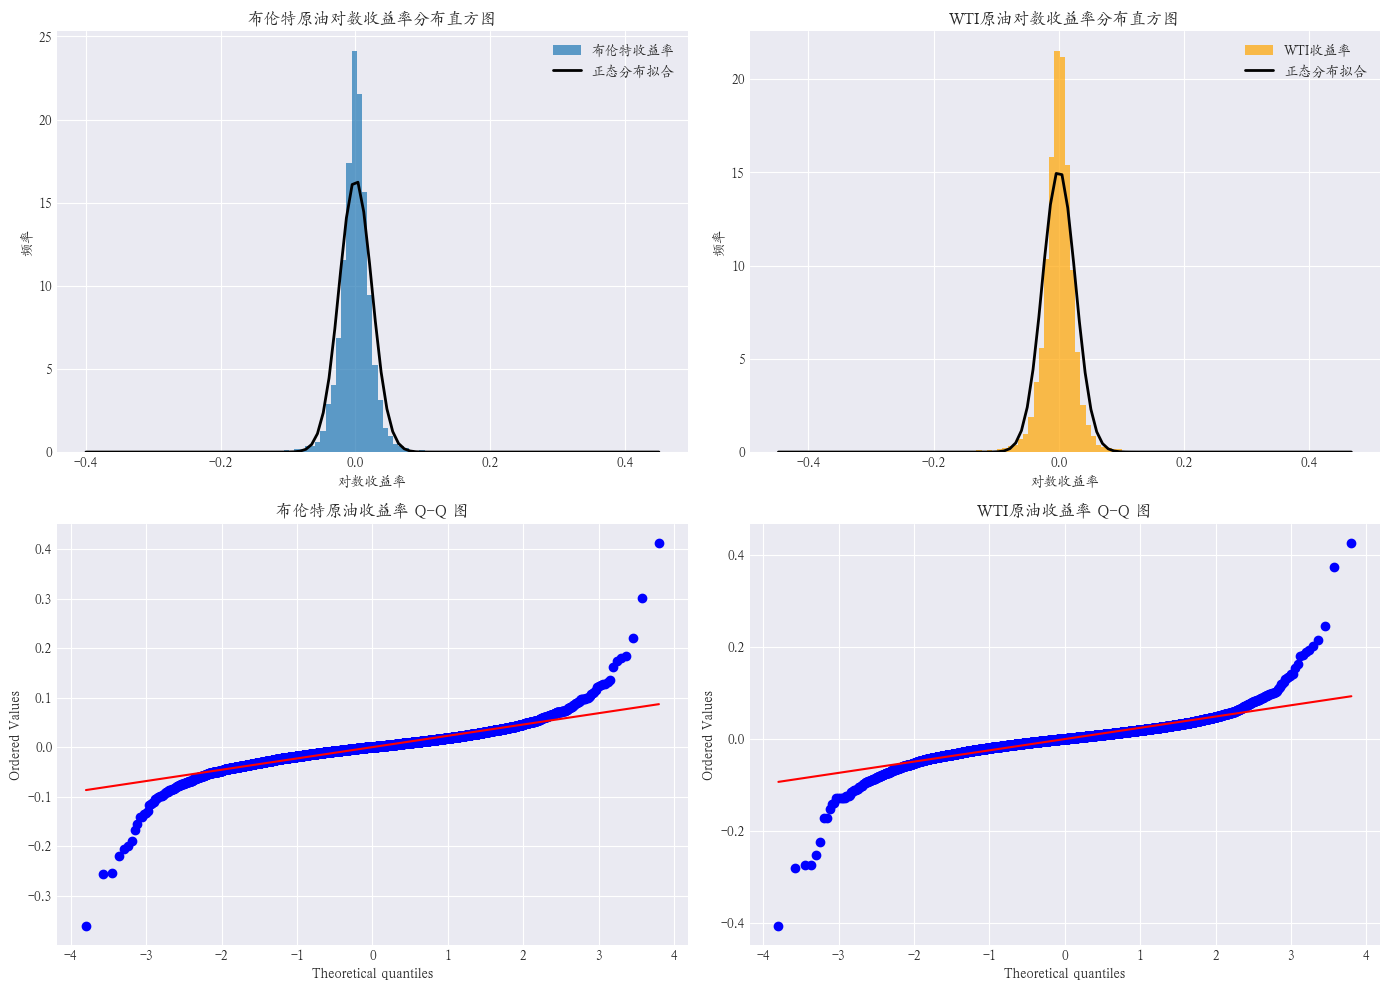


--- Jarque-Bera 正态性检验结果 ---
布伦特原油 -> JB统计量: 246584.33, p值: 0.0
WTI原油 -> JB统计量: 303944.47, p值: 0.0
布伦特原油收益率在5%的显著性水平下拒绝正态分布的原假设。
WTI原油收益率在5%的显著性水平下拒绝正态分布的原假设。


In [ ]:
# --- 正态性检验 ---

# 设置图形大小
plt.figure(figsize=(14, 10))

# 1. 布伦特原油收益率的直方图
plt.subplot(2, 2, 1)
plt.hist(merged_df['log_ret_brent'], bins=100, density=True, alpha=0.7, label='布伦特收益率')
# 叠加正态分布曲线以供比较
mu, std = stats.norm.fit(merged_df['log_ret_brent'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='正态分布拟合')
plt.title('布伦特原油对数收益率分布直方图')
plt.xlabel('对数收益率')
plt.ylabel('频率')
plt.legend()

# 2. WTI原油收益率的直方图
plt.subplot(2, 2, 2)
plt.hist(merged_df['log_ret_wti'], bins=100, density=True, alpha=0.7, color='orange', label='WTI收益率')
# 叠加正态分布曲线
mu, std = stats.norm.fit(merged_df['log_ret_wti'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='正态分布拟合')
plt.title('WTI原油对数收益率分布直方图')
plt.xlabel('对数收益率')
plt.ylabel('频率')
plt.legend()

# 3. 布伦特原油收益率的Q-Q图
plt.subplot(2, 2, 3)
stats.probplot(merged_df['log_ret_brent'], dist="norm", plot=plt)
plt.title('布伦特原油收益率 Q-Q 图')

# 4. WTI原油收益率的Q-Q图
plt.subplot(2, 2, 4)
stats.probplot(merged_df['log_ret_wti'], dist="norm", plot=plt)
plt.title('WTI原油收益率 Q-Q 图')

# 自动调整子图布局
plt.tight_layout()
plt.show()

# --- Jarque-Bera 统计检验 ---
jb_brent_stat, jb_brent_pvalue, _, _ = jarque_bera(merged_df['log_ret_brent'])
jb_wti_stat, jb_wti_pvalue, _, _ = jarque_bera(merged_df['log_ret_wti'])

print("\n--- Jarque-Bera 正态性检验结果 ---")
print(f"布伦特原油 -> JB统计量: {jb_brent_stat:.2f}, p值: {jb_brent_pvalue}")
print(f"WTI原油 -> JB统计量: {jb_wti_stat:.2f}, p值: {jb_wti_pvalue}")

if jb_brent_pvalue < 0.05:
    print("布伦特原油收益率在5%的显著性水平下拒绝正态分布的原假设。")
else:
    print("布伦特原油收益率在5%的显著性水平下不拒绝正态分布的原假设。")

if jb_wti_pvalue < 0.05:
    print("WTI原油收益率在5%的显著性水平下拒绝正态分布的原假设。")
else:
    print("WTI原油收益率在5%的显著性水平下不拒绝正态分布的原假设。")

In [10]:
# --- 平稳性检验 (ADF Test) ---

# 对布伦特原油收益率进行ADF检验
adf_brent_result = adfuller(merged_df['log_ret_brent'])
# 对WTI原油收益率进行ADF检验
adf_wti_result = adfuller(merged_df['log_ret_wti'])

print("\n--- ADF 平稳性检验结果 ---")
print(f"布伦特原油收益率 -> ADF统计量: {adf_brent_result[0]:.4f}, p值: {adf_brent_result[1]:.4f}")
print(f"WTI原油收益率 -> ADF统计量: {adf_wti_result[0]:.4f}, p值: {adf_wti_result[1]:.4f}")

if adf_brent_result[1] < 0.05:
    print("布伦特原油收益率序列在5%的显著性水平下是平稳的。")
else:
    print("布伦特原油收益率序列在5%的显著性水平下是非平稳的。")

if adf_wti_result[1] < 0.05:
    print("WTI原油收益率序列在5%的显著性水平下是平稳的。")
else:
    print("WTI原油收益率序列在5%的显著性水平下是非平稳的。")


--- ADF 平稳性检验结果 ---
布伦特原油收益率 -> ADF统计量: -20.8636, p值: 0.0000
WTI原油收益率 -> ADF统计量: -15.2956, p值: 0.0000
布伦特原油收益率序列在5%的显著性水平下是平稳的。
WTI原油收益率序列在5%的显著性水平下是平稳的。


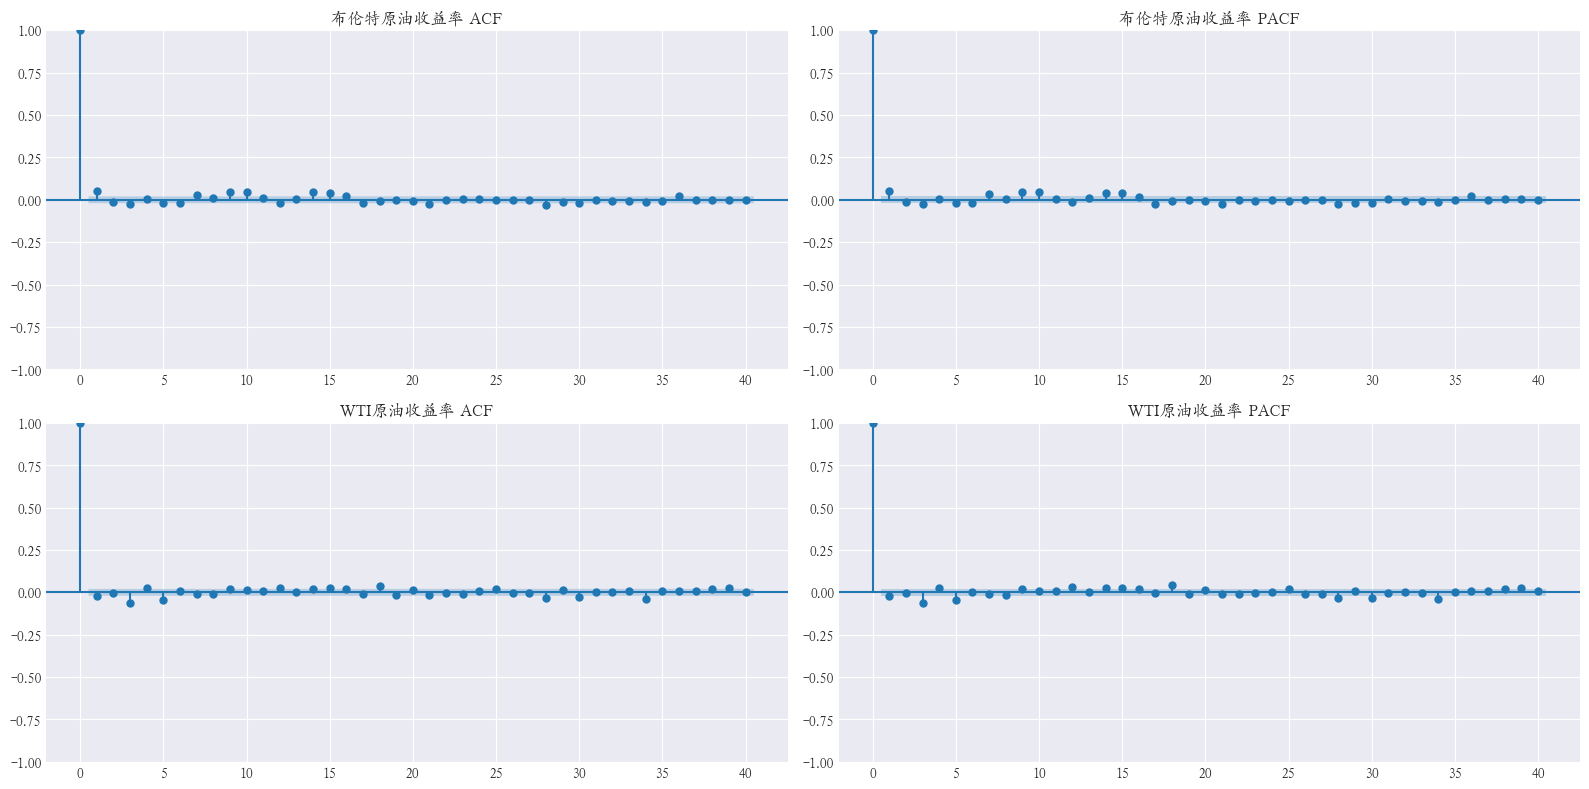

In [11]:
# --- 自相关性分析 (ACF 和 PACF) ---

# 创建一个2x2的图形布局
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# 绘制布伦特原油的ACF和PACF图
plot_acf(merged_df['log_ret_brent'], lags=40, ax=axes[0, 0])
axes[0, 0].set_title('布伦特原油收益率 ACF')
plot_pacf(merged_df['log_ret_brent'], lags=40, ax=axes[0, 1])
axes[0, 1].set_title('布伦特原油收益率 PACF')

# 绘制WTI原油的ACF和PACF图
plot_acf(merged_df['log_ret_wti'], lags=40, ax=axes[1, 0])
axes[1, 0].set_title('WTI原油收益率 ACF')
plot_pacf(merged_df['log_ret_wti'], lags=40, ax=axes[1, 1])
axes[1, 1].set_title('WTI原油收益率 PACF')

# 自动调整布局并显示图形
plt.tight_layout()
plt.show()